## Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


### Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [111]:
# regs = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')  # Датафрейм с датой регистрации каждого пользователя
regs = pd.read_csv('problem1-reg_data.csv', sep=';')

regs['reg_at'] = pd.to_datetime(regs['reg_ts'], unit='s')

regs.head()


,reg_ts,uid,reg_at
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,947802447,3,2000-01-13 22:27:27
3,959523541,4,2000-05-28 14:19:01
4,969103313,5,2000-09-16 11:21:53


In [112]:
regs.uid.duplicated().sum()  # Проверка на дубликаты пользователей


0

In [113]:
# logs = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')  # Датафрейм с датами заходов пользователей

logs = pd.read_csv('problem1-auth_data.csv', sep=';')

logs['date_at'] = pd.to_datetime(logs['auth_ts'], unit='s')

logs.head()


,auth_ts,uid,date_at
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46
3,933393015,2,1999-07-31 03:50:15
4,933875379,2,1999-08-05 17:49:39


In [114]:
task1_df = logs[['uid', 'date_at']].merge(regs[['uid', 'reg_at']], on='uid')  # Логи + регистрации по дате-пользователю

task1_df.head()  # Датафрейм для построения Retention'a


,uid,date_at,reg_at
0,1,1998-11-18 09:43:43,1998-11-18 09:43:43
1,2,1999-07-22 22:38:09,1999-07-22 22:38:09
2,2,1999-07-25 16:46:46,1999-07-22 22:38:09
3,2,1999-07-31 03:50:15,1999-07-22 22:38:09
4,2,1999-08-05 17:49:39,1999-07-22 22:38:09


In [115]:
test1_df = task1_df.copy()  # Проверка на дубли в записях (строка id-дата лога-дата регистрации д.б. уникальна)

test1_df['date_at'] = test1_df['date_at'].apply(lambda x: x.strftime('%Y-%m-%d'))
test1_df['reg_at'] = test1_df['reg_at'].apply(lambda x: x.strftime('%Y-%m-%d'))

test1_df.duplicated().sum()


0

In [116]:
'''
Функция подсчета Retenion'a для выбранного интервала - когорты пользователей, зарегистрировавшихся в 
диапазоне coh_start и coh_finish, основная идея - по причине того, что запись (лог) захода уникален в
грануляции дата-пользователь, вычисляется разница в днях между датой захода пользователя и датой регистрации,
считается количество этих разниц каждого из возможных дней в пределах 365 (года) и делится на общее
число уникальных пользователей в выбранной когорте.

Фукнция визуализации отображает зависимость показателя Retention для каждого дня на платформе по возрастанию
начиная с 1-го дня, 0-ой день рассматривается как день регистрации пользователя

'''

def retention_rate(df, coh_start, coh_finish):
    df_cohort = df[(df['reg_at'] >= coh_start) & (df['reg_at'] <= coh_finish)]
    df_cohort['diff'] = (df_cohort['date_at'] - df_cohort['reg_at']).dt.days
    df_cohort = df_cohort[df_cohort['diff'] <= 365]

    retention = df_cohort[df_cohort['diff'] > 0]['diff'].value_counts().sort_index()
    retention_df = pd.DataFrame(retention).rename(columns={'diff':'returns'})
    retention_df.index = retention_df.index.astype('int64')
    retention_df['users'] = df_cohort.uid.nunique()
    retention_df['retention'] = (retention_df['returns'] / retention_df['users']) * 100
    ouput_df = retention_df.round(3)
    
    return ouput_df

def viz(df):
    plt.figure(figsize=(20, 10))
    plt.style.use('ggplot')
    sns.lineplot(data=df['retention'])
    plt.title("Retention rate from '{}' to '{}' registration date".format(coh_start, coh_finish) , fontsize=18)
    plt.xlabel('Days', fontsize=15)
    plt.ylabel('Retention %', fontsize=15)
    plt.xticks(range(0, df.index.max(), 10), rotation=90) 
    plt.yticks(np.arange(0, retention_rate(task1_df, coh_start, coh_finish).retention.max(), 0.5))
    plt.show()
    

In [117]:
coh_start = '2020-06-01'   # Выбирается диапазон когорты пользователей через левую и правую границу, индекс - номер дня
coh_finish = '2020-06-30'

retention_rate(task1_df, coh_start, coh_finish)


,returns,users,retention
1,1535,40451,3.795
2,1761,40451,4.353
3,2016,40451,4.984
4,2251,40451,5.565
5,2601,40451,6.430
...,...,...,...
110,71,40451,0.176
111,59,40451,0.146
112,33,40451,0.082
113,23,40451,0.057


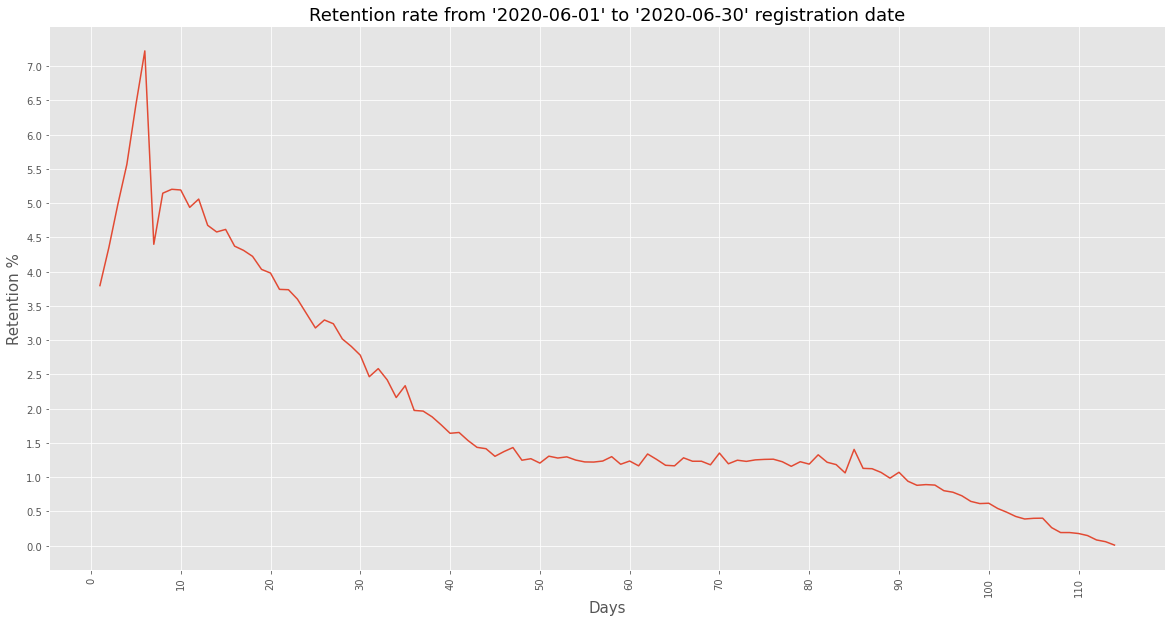

In [118]:
viz(retention_rate(task1_df, coh_start, coh_finish))  # Визуализация полученого показателя


### Retention v.2 (первые 14 дней для месячных когорт)

In [119]:
'''
Альтернативная функция подсчета Retenion'a для выбранного интервала, зарегистрировавшихся в 
диапазоне coh_start и coh_finish, диапазон разделяется на когорты по месяцу регистрации,
доля возвратов рассматривается в первые 14 дней на платформе относительно всех уникальных
пользователей в выбранных когортах

'''

def retention_table(df, cohstart, cohfinish):
    df_cohort = df[(df['reg_at'] >= coh_start) & (df['reg_at'] <= coh_finish)]
    df_cohort['diff'] = (df_cohort['date_at'] -  df_cohort['reg_at']).dt.days
    df_cohort = df_cohort[df_cohort['diff'] <= 14]
    df_cohort['date_at'] = df_cohort['date_at'].apply(lambda x: x.strftime('%Y-%m'))
    df_cohort['reg_at'] = df_cohort['reg_at'].apply(lambda x: x.strftime('%Y-%m'))

    retention_table = df_cohort.groupby(['reg_at', 'diff']).agg({'date_at':'count'}).reset_index()
    retention_table = retention_table.merge(retention_table[retention_table['diff'] == 0], on='reg_at') \
                                     .rename(columns={'diff_x':'day'})
    retention_table['retRate'] = retention_table['date_at_x'] / retention_table['date_at_y']

    user_retention = retention_table[['reg_at', 'day', 'retRate']].query('day > 0') \
                        .pivot(index='reg_at', columns='day', values='retRate')

    plt.figure(figsize=(15,7))
    sns.heatmap(data=user_retention, annot=True, fmt='.2%', vmin=user_retention.values.min(),
                vmax=user_retention.values.max(), cmap='YlOrBr')
    plt.yticks(rotation=0) 
    plt.show()


In [120]:
coh_start = '2018-01-01'
coh_finish = '2018-08-31'


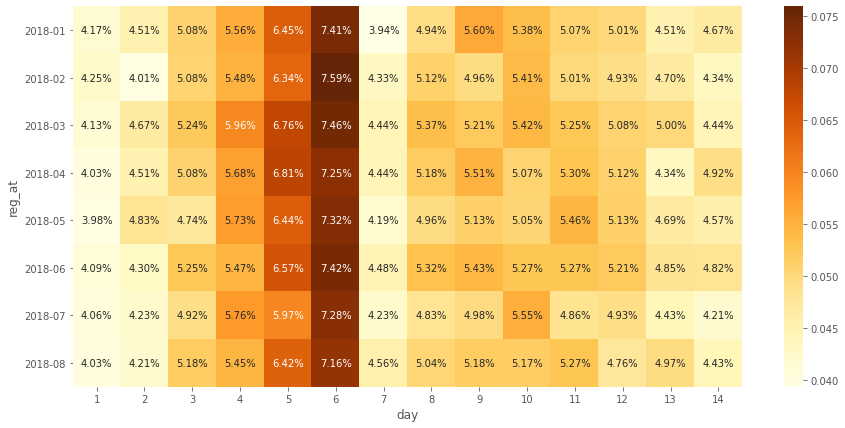

In [121]:
retention_table(task1_df, coh_start, coh_finish)


##### Выводы:

Прослеживается тенденция увеличения возврата пользователей к 6-ому дню жизни, то есть примерно через неделю после регистрации, возможно в этот период настроена почтовая рассылка или пуш-уведомления, стимулирующие пользователей вернуться в игру (продукт).

Однако в первые 3-4 дня ретеншн обычно максимален и далее должен убывать, не имея сильных возрастаний, поэтому требуется уточнение о специфике продукта и жанре мобильной игры.

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [122]:
task2_df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')  # Исходный датафрейм

task2_df.head()


,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [123]:
# Ключевые метрики для обеих групп

users_a = task2_df.query('testgroup == "a"')['user_id'].nunique()
users_b = task2_df.query('testgroup == "b"')['user_id'].nunique()

pay_users_a = task2_df.query('testgroup == "a" & revenue > 0')['user_id'].nunique()
pay_users_b = task2_df.query('testgroup == "b" & revenue > 0')['user_id'].nunique()

conv_a = np.round(pay_users_a / users_a, 4)
conv_b = np.round(pay_users_b / users_b, 4) 

arpu_a = task2_df.query('testgroup == "a"')['revenue'].sum() / users_a
arpu_b = task2_df.query('testgroup == "b"')['revenue'].sum() / users_b

arppu_a = task2_df.query('testgroup == "a"')['revenue'].sum() / pay_users_a
arppu_b = task2_df.query('testgroup == "b"')['revenue'].sum() / pay_users_b

print('Группа A - {} пользователей, из них {} платящих c конверсией {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_a, pay_users_a, conv_a, arpu_a, arppu_a))
print('Группа B - {} пользователей, из них {} платящих c конверсией {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_b, pay_users_b, conv_b, arpu_b, arppu_b))


Группа A - 202103 пользователей, из них 1928 платящих c конверсией 0.0095, ARPU: 25.414, ARPPU: 2663.998
Группа B - 202667 пользователей, из них 1805 платящих c конверсией 0.0089, ARPU: 26.751, ARPPU: 3003.658


##### Рассмотрим подробнее пользователей, которые принесли ненулевой доход т.к. доля платящих пользователей меньше 1%

In [124]:
paying_groups_df = task2_df[task2_df['revenue'] > 0]  # Отбор пользователей с доходом > 0

paying_a_group = paying_groups_df.query('testgroup == "a"')[['revenue']]  # Фильтр по группам
paying_a_group.name = 'Group A'
paying_b_group = paying_groups_df.query('testgroup == "b"')[['revenue']]
paying_b_group.name = 'Group B'


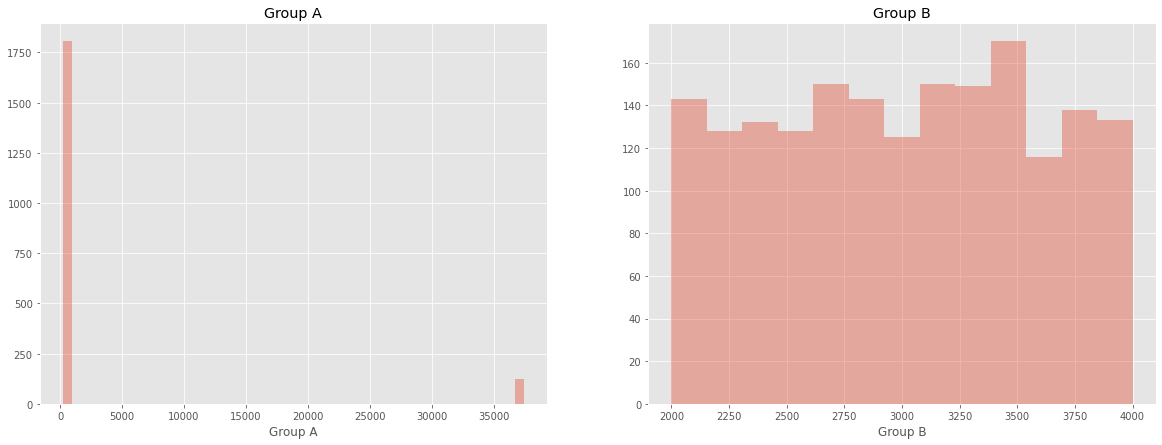

In [125]:
plt.figure(figsize=(20, 7))  # Гистограмма распределений контрольной и тестовой группы

for i,group in enumerate([paying_a_group, paying_b_group]):
    plt.subplot(1, 2, i+1)
    plt.title(group.name)
    sns.distplot(group, kde=False)
    

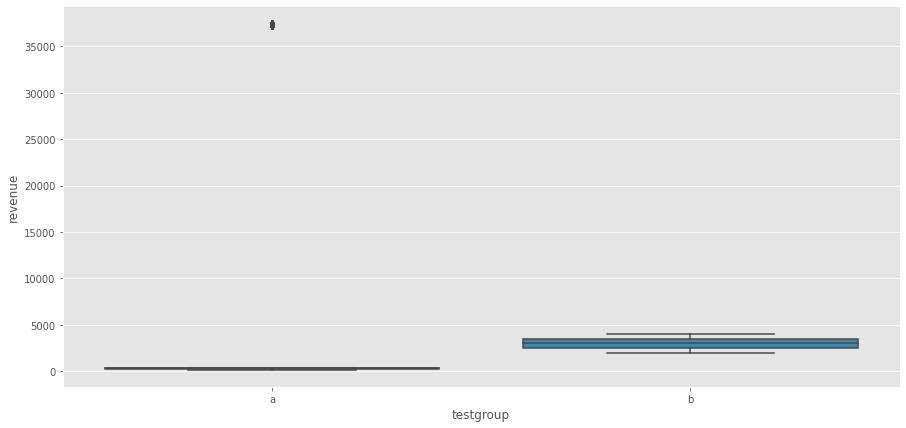

In [126]:
plt.figure(figsize=(15, 7))  # Боксплоты распределений контрольной и тестовой группы

sns.boxplot(x="testgroup", y="revenue", data=paying_groups_df)

plt.show()


In [127]:
# Количество пользователей группы A - принесшие большую прибыль и все платящие из этой группы

print(len(paying_a_group.query('revenue > 30000')),
      len(paying_a_group))


123 1928


In [128]:
# Доля прибыли с таких пользователей от общей прибыли

print('{:.2f}'.format(*paying_a_group.query('revenue > 30000').sum() / paying_a_group.sum()))

0.89


##### Промежуточные выводы:

Как видно из визуализаций, в контрольной группе (A) имеется ряд пользователей (китов), которые принесли несоизмеримый с большим числом пользователей из группы доход, причин такого явления может быть несколько, например:

1. Акционные предложения, которые были использованы в контрольной группе, способствовали привлечению таких пользователей, которые сделали большую часть выручки.

2. Некорректная работа системы сплитования, пользователи изначально были разделены по группам с влиянием какого-то внешнего эффекта, который не был взят во внимание.

3. Подразумевается наличие третьей группы для проведения ABB тестирования, где на группы B предлагаются различные наборы акционных предложений, а группа А - это стандартное поведение пользователей без проведения каких-либо акций, и здесь требуется уточнение формулировки теста.

Какие дальнейшие сценарии исследования возможны:

1. Анализировать результаты эксперимента всех пользователей (даже с нулевым доходом) без удаления выбросов.
2. Отфильтровать пользователей, которые принесли доход, оставив при этом пользователей, сильно отличающихся по уровню дохода с них (много больше).
3. Удалить из выборки пользователей с нулевым доходом, а также пользователей, сильно отличающихся от основной выборки по уровню дохода.

Разные сценарии предполагают разные метрики для оценки успешности тестирования, например, в первом случае важно учесть **конверсию** и **ARPU**, во втором - **ARPPU**, т.к. условно первые 2 метрики вычислить только на платящих пользователях не получится, третий сценарий - мы заключаем, что система сплитования работает некорректно, но при этом мы отбрасываем значимую часть выручки, что не совсем разумно.

In [130]:
# Оценка стат.тестов на исходных группах

task2_df['paying_user'] = np.where(task2_df['revenue'] > 0, 1, 0)

rev_a_group = task2_df.query('testgroup == "a"')['revenue']
rev_b_group = task2_df.query('testgroup == "b"')['revenue']

print('- Ст.отклонения платежа в группе A = {:.3f}, группе B = {:3f}'
          .format(np.std(paying_a_group)[0], np.std(paying_b_group)[0]))

print('- P-value для U-критерия Манна-Уитни = {:.3f}'
          .format(st.mannwhitneyu(rev_a_group, rev_b_group)[1]))

stat, p, dof, expected = st.chi2_contingency(pd.crosstab(task2_df.testgroup, task2_df.paying_user))


print('- Конверсия в платеж группы A больше конверсии группы B на {:.4f}'.format(conv_a - conv_b))
print('- P-value для критерия Хи-квадрат конверсий = {:.3f}'.format(p))


- Ст.отклонения платежа в группе A = 9046.693, группе B = 572.461067
- P-value для U-критерия Манна-Уитни = 0.031
- Конверсия в платеж группы A больше конверсии группы B на 0.0006
- P-value для критерия Хи-квадрат конверсий = 0.036


#### Выводы:

- Исходя из полученных графиков и тестов (условия для осознанного применения параметрики не выполнены, нет основания утверждать о гомогенности дисперсий по оценке теста Левена, распределения отличаются от нормальных, разное количество наблюдений), а также согласно критерию Манна-Уитни доход групп статистически значимо различается  т.к. p-value для теста < 0.05 (фиксированный уровень значимости с соответствующим уровнем доверия), но кроме этого на данном этапе мы больше ничего сказать не можем - какая именна группа лучше и почему.
- Согласно исследованию показателя конверсии - выбор в пользу группы А (конверсия на данных больше, статистика выявила значимые различия)
- Попробуем применить бутстрап на группах из платящих пользователей по оценке среднего, т.е. вывод будет делаться на основании показателя **ARPPU**, посмотрим тем же методом показатель **ARPU** на всех данных и **конверсию**.

In [131]:
'''
Предлагаемый вариант оценивания гипотезы о различии двух групп через бутстрап реализуется
путем оценивания 2.5% и 97.5% перцентиля теоретического распределения показателя, в данном случае 
среднего ресэмплированной разницы двух выборок, интервал внутри 2.5% и 97.5% перцентиля включает в себя
95% данных, другими словами 95% доверительный интервал для нашего показателя, бизнес смысл этого показателя - ARPPU.
В случае, если он включает  в себя 0, то у нас нет основания отклонить нулевую гипотезу о значимом различии наших
двух групп, p-value вычисляется как вероятность отклониться от нуля в центре по нормальному распределению со средним 0
и стандартным отклонением откл. = 1, т.к. предполагается, что если группы равны, среднее генеральной совокупности
такого распределения будет равно 0.

'''


def bootstrap(x, y, n, bootstrap_conf_level=0.95):
    
    boot_len = max([len(x), len(y)])
    boot_data = []
    
    for i in tqdm(range(n)): 
        samples_1 = x.sample(boot_len, replace = True).values
        samples_2 = y.sample(boot_len, replace = True).values
        boot_data.append(np.mean(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = st.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    plt.figure(figsize=(10, 7))
    plt.hist(pd_boot_data[0], bins = 50)
    plt.vlines(ci, 0, 600, linestyle='--', colors=['black'])
    plt.xlabel('mean_diff')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    print('2.5%-ый перцентиль:{:.2f}, 97.5%-ый перцентиль:{:.2f}, p-value: {:.3f}'
          .format(ci.values[0][0].astype('float64'), ci.values[1][0].astype('float64'), p_value))

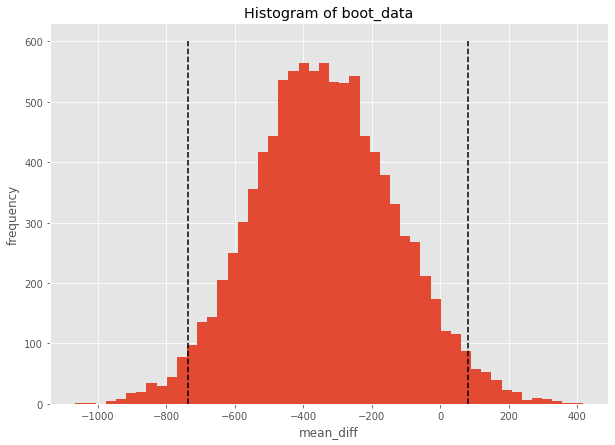

2.5%-ый перцентиль:-736.79, 97.5%-ый перцентиль:79.60, p-value: 0.103


In [132]:
bootstrap(paying_a_group, paying_b_group, 10000)

Интерпретация результатов применения бутстрапа на платящих пользователях:
- 95% доверительный интервал для исследуемого показателя включает в себя 0, а также полученное p-value > 0.05, т.е. с вероятностью 95% у нас нет оснований отклонить нулевую гипотезу об отсутствии различий **ARPPU** в двух группах.

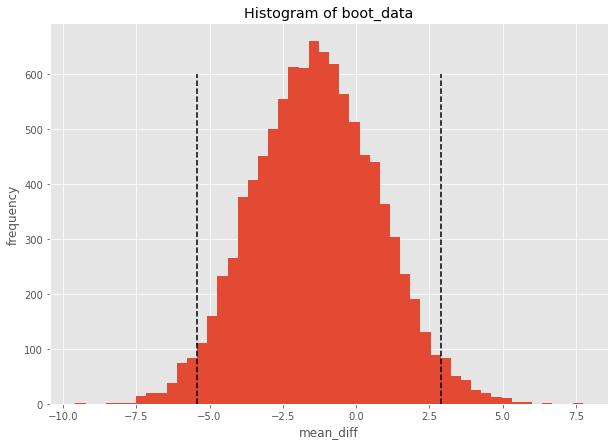

2.5%-ый перцентиль:-5.44, 97.5%-ый перцентиль:2.90, p-value: 0.526


In [133]:
# Используем бутстрап на группах, состоящих из всех пользователей вместе с неплатящими, бизнес метрика в этом случае - ARPU

bootstrap(task2_df.query('testgroup == "a"')['revenue'], 
          task2_df.query('testgroup == "b"')['revenue'], 
          10000)

- Аналогично, 95% доверительный интервал для исследуемого показателя включает в себя 0, а также полученное p-value > 0.05, т.е. с вероятностью 95% у нас нет оснований отклонить нулевую гипотезу об отсутствии различий **ARPU** в двух группах.

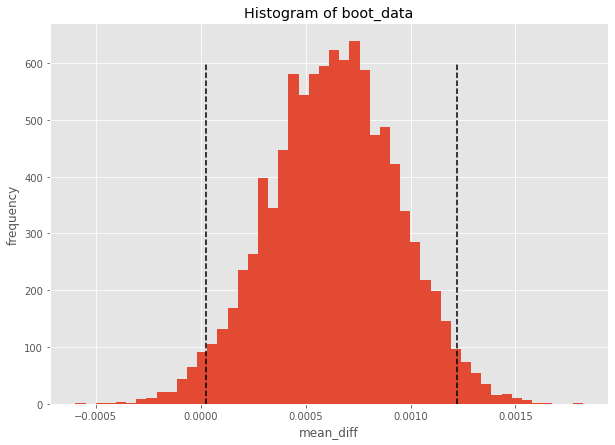

2.5%-ый перцентиль:0.00, 97.5%-ый перцентиль:0.00, p-value: 0.038


In [134]:
x = task2_df.query('testgroup == "a"')['paying_user']
y = task2_df.query('testgroup == "b"')['paying_user']

boot_len = max([len(x), len(y)])
boot_data = []

for i in tqdm(range(10000)): 
    samples_1 = x.sample(boot_len, replace = True).values
    samples_2 = y.sample(boot_len, replace = True).values
    conv_1 = samples_1.sum() / samples_1.shape[0]
    conv_2 = samples_2.sum() / samples_2.shape[0]
    boot_data.append(conv_1 - conv_2)

pd_boot_data = pd.DataFrame(boot_data)

left_quant = (1 - 0.95)/2
right_quant = 1 - (1 - 0.95) / 2
ci = pd_boot_data.quantile([left_quant, right_quant])

p_1 = st.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
p_2 = st.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
p_value = min(p_1, p_2) * 2

plt.figure(figsize=(10, 7))
plt.hist(pd_boot_data[0], bins = 50)
plt.vlines(ci, 0, 600, linestyle='--', colors=['black'])
plt.xlabel('mean_diff')
plt.ylabel('frequency')
plt.title("Histogram of boot_data")
plt.show()

print('2.5%-ый перцентиль:{:.2f}, 97.5%-ый перцентиль:{:.2f}, p-value: {:.3f}'
      .format(ci.values[0][0].astype('float64'), ci.values[1][0].astype('float64'), p_value))

- 95% доверительный интервал для разности конверсий не включает в себя 0, а также полученное p-value < 0.05, т.е. с вероятностью 95% у нас есть основания отклонить нулевую гипотезу и сделать выбор в пользу группы А по **конверсии**.

#### Общие выводы по второму заданию:

**В результате исследования:**
- Конверсия в платящего пользователя выше у контрольный группы, в ней большей платящих пользователей, также она содержит пользователей, которые принесли значимо высокий доход по сравнению с остальными пользователями, конверсии по критерию Хи-квадрат различаются и согласно результатам бутстрапа мы предполагаем, что конверсия группы А лучше, чем группы B.
- По результатам применения U-критерия Манна-Уитни можем сделать стат. значимый вывод о наличии различий в группах, однако сказать какая группа лучше и по какому показателю по этому тесту мы не можем.
- Применен бутстрап на платящих пользователях для оценки ARPPU и на всех пользователях для оценки ARPU, значимых различий на имеющихся данных выявлено не было.

**Рекомендации бизнесу**:
- Если цель бизнеса - привлекать как можно больше "китов", пользователей с наибольшим доходом как в контрольной группе, при наличии теоретического CRM отдела для работы с такими пользователями, цель которого не допускать отток и мотивировать их на внутриигровые траты - можно сделать выбор в пользу акционных предложений группы A, однако не гарантируется, что привлечение таких пользователей будет стабильным, требуются дополнительные исследования.
- Если рассматривать общую картину - на основании проведенного исследования мы не выявили значимых различий в показателях APPU и ARPPU двух групп, конверсия группы А значимо лучше, следовательно по совокупности показателей 1) ARPU_A <> ARPU_B, 2) ARPPU_A <> ARPPU_B, 3) Conversion_A > Conversion_B -> **выбор делается в пользу акционных предложений контрольной группы А.**


### Задание 3


*В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?*


- **DAU** (активные игроки)
- **Retention** (возврат старых игроков, которые ранее были не активны, в разных разрезах, напр. неактивные более месяца, года и т.д.)
- **доля реактивированных игроков**
- **LTV** (ивент может увеличить средний LTV пользователей, т.к. они захотят полностью пройти ивентовые уровни ради получения уникальных наград, прибегнув к покупке улучшений/бустов для персонажей за реальные деньги)
- **ARPDAU** (повышение средних чеков у активных игроков в дни проведения событий)
- Также можно рассмотреть воронки прохождения новых уровней для оценивания сложности и поведения игроков, что может влиять на Retention.


*Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?*


Метрики сильно не изменятся, однако, в целом данное решение может негативно повлиять на пользователей, решение, которое повлечет за собой увеличение **оттока** пользователей, повышение **Lose Rate'a**, игроки будут терять интерес к игре, из-за того, что они будут терять свой прогресс и заново проходить одни и те же уровни несколько раз. Но опять же зависит от игры - есть ряд кейсов, когда ретеншн игроков, которые больше проигрывают, чем выигрывают, выше, по причине повышения интереса и духа соревнований, желания добиться прогресса, цена которого выше из-за сложности пройденного к нему пути.